In [1]:
import numpy as np # linear algebra
import pytorch_lightning as pl 
import torch.nn as nn 
import matplotlib.pyplot as plt
from src.ptp.globals import TARGET_DATA_DIR, TRAINING_DIR
import os 
import torch
import nibabel as nib  
from monai.data import MetaTensor
from skimage.metrics import structural_similarity

from src.ptp.models.building_blocks import InvertedResidual, ResNetBlock3D, ConvBNReLU

from pathlib import Path
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes
from src.ptp.models.gan.generator import Generator
from src.ptp.models.gan.discriminator import Discriminator
from src.ptp.models.gan.gan import GAN
from src.ptp.models.utils import num_trainable_params, num_params

import os
from pathlib import Path


In [2]:
len(os.listdir(TRAINING_DIR))

2

In [3]:
discriminator = Discriminator(1)

In [4]:
print(num_params(discriminator))
print(num_trainable_params(discriminator))

1192816
1192816


In [5]:
input_pt = torch.rand((10, 1, 256, 256, 256))

In [6]:
discriminator(input_pt).shape

torch.Size([10, 1])

The authors used inverted resnet block

In [7]:
sample_tensor = torch.randn((1, 3, 10, 10, 10))

In [25]:
inv_residual = InvertedResidual(3, oup=3, stride=1, expand_ratio=0.5)
output = inv_residual(sample_tensor)

In [26]:
output.shape

torch.Size([1, 3, 10, 10, 10])

In [10]:
resnet_block = ResNetBlock3D(3, nn.ReLU)

In [11]:
resnet_input = torch.randn((1, 3, 10, 10, 10))
resnet_result = resnet_block(resnet_input)

In [12]:
resnet_result.shape

torch.Size([1, 3, 10, 10, 10])

In [13]:
t1 = torch.randn((1, 3, 10, 10, 10))
t2 = torch.randn((1, 3, 10, 10, 10))

torch.cat([t1, t2], axis=1).shape

torch.Size([1, 6, 10, 10, 10])

In [14]:
gen = Generator()

In [15]:
t1 = torch.randn((1, 1, 256, 256, 256))

In [16]:
output = gen(t1)

In [17]:
output.shape

torch.Size([1, 1, 256, 256, 256])

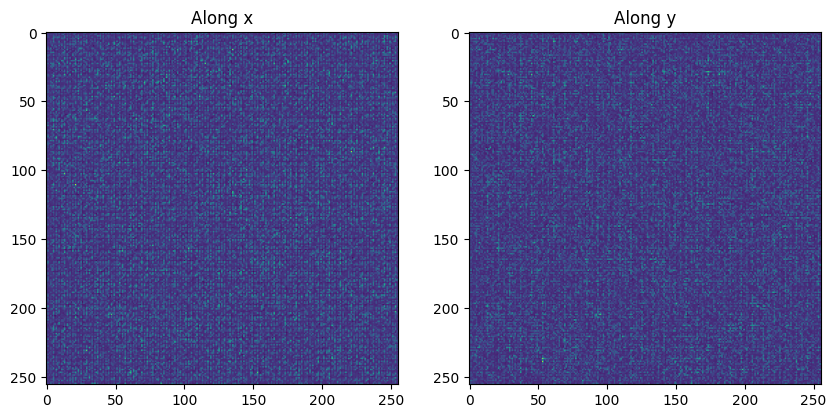

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Along x')
plt.imshow(output[0, 0, 0, ...].detach().numpy())
plt.subplot(1, 2, 2)
plt.title('Along y')
plt.imshow(output[0, 0, :, 100, :].detach().numpy())

In [19]:
output.mean()

tensor(0.3120, grad_fn=<MeanBackward0>)

The input to the generator is a corrupted image with some added random noise. 

In [20]:
percentile = 5

In [21]:
gan = GAN(percentile)

In [22]:
print(num_trainable_params(gan.G))
print(num_trainable_params(gan.D))

238435
1192816


In [23]:
max_epochs = 10

checkpoint_dir = Path(TRAINING_DIR / 'gan')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    fast_dev_run=True
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 238 K 
1 | D    | Discriminator | 1.2 M 
---------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.725     Total estimated model params size (MB)
Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 1/1 [00:47<00:00,  0.02it/s, g_loss_step=0.770, d_loss_step=1.170, train_loss_step=1.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [01:15<00:00,  0.01it/s, g_loss_step=0.770, d_loss_step=1.170, train_loss_step=1.940, g_loss=1.070, d_loss=0.680, val_loss=1.750, g_loss_epoch=0.770, d_loss_epoch=1.170, train_loss_epoch=1.940]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [01:15<00:00,  0.01it/s, g_loss_step=0.770, d_loss_step=1.170, train_loss_step=1.940, g_loss=1.070, d_loss=0.680, val_loss=1.750, g_loss_epoch=0.770, d_loss_epoch=1.170, train_loss_epoch=1.940]


In [83]:
def plot_losses(gan_net, n_epochs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(n_epochs), np.array([x.cpu().detach().numpy() for x in gan_net.discriminator_real_loss]))

In [85]:
np.array([x.cpu().detach().numpy() for x in gan.discriminator_fake_loss])

array([0.6761267 , 0.7636329 , 0.6394905 , 0.46585733, 0.46556723,
       0.520235  , 0.366861  , 0.678452  , 0.7637863 , 0.65571713,
       0.64111996, 1.6098297 , 1.2247965 , 1.1353593 , 0.6032295 ,
       0.5694367 , 0.3289241 , 0.56147647, 0.60874736, 0.55783075],
      dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

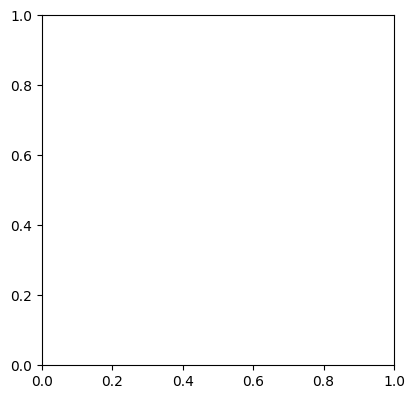

In [84]:
plot_losses(gan, max_epochs)

dd

In [60]:
MODEL_PATH = checkpoint_dir / 'gan'

In [61]:
torch.save(gan.state_dict(), MODEL_PATH)

In [62]:
gan_2 = GAN(5)
gan_2.load_state_dict(torch.load(MODEL_PATH))
gan_2.eval()

GAN(
  (G): Generator(
    (down1): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (down2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (l1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): ConvBNReLU(
          (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=32, bias=False)
          (1): B

In [63]:
gan_2.prepare_data()
train_loader = gan_2.train_dataloader()

Re-generated trained samples

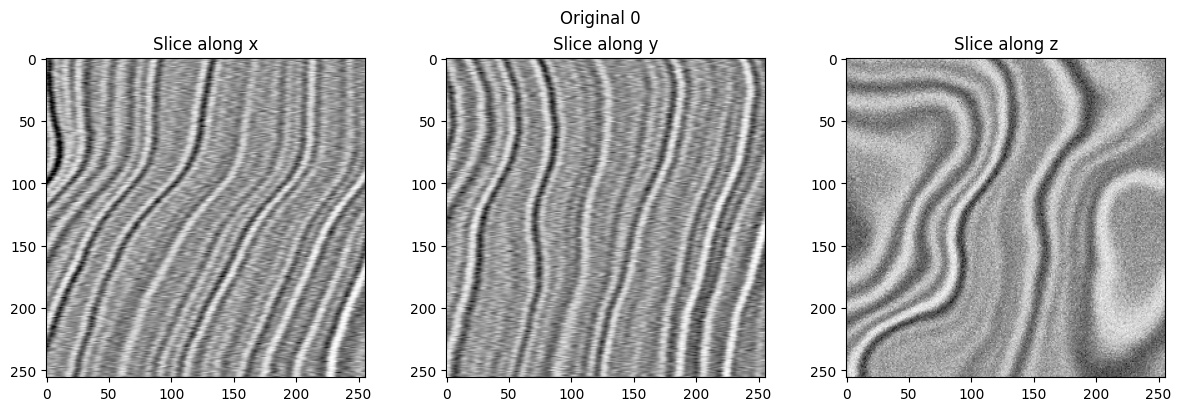

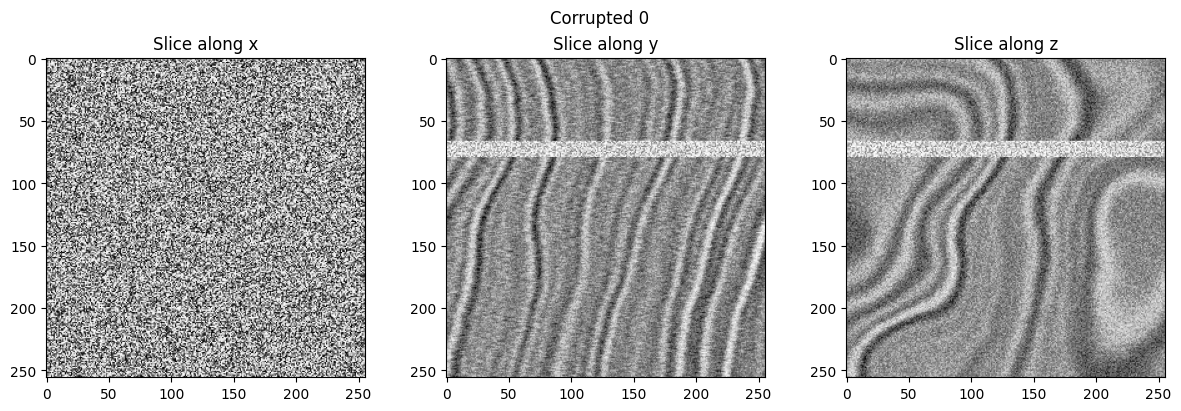

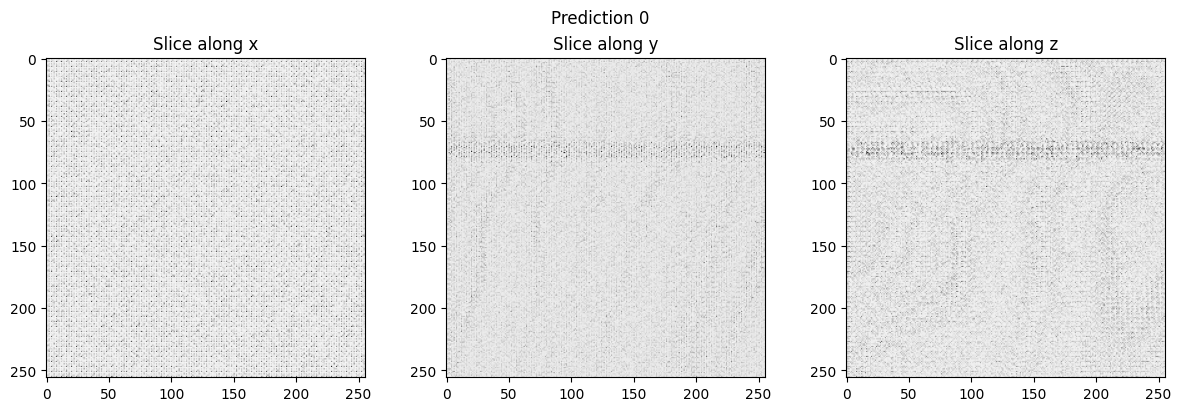

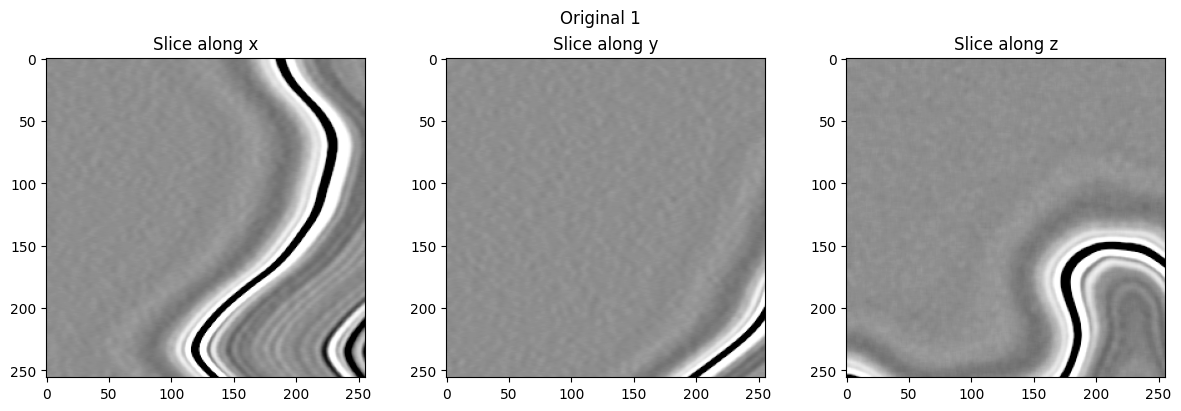

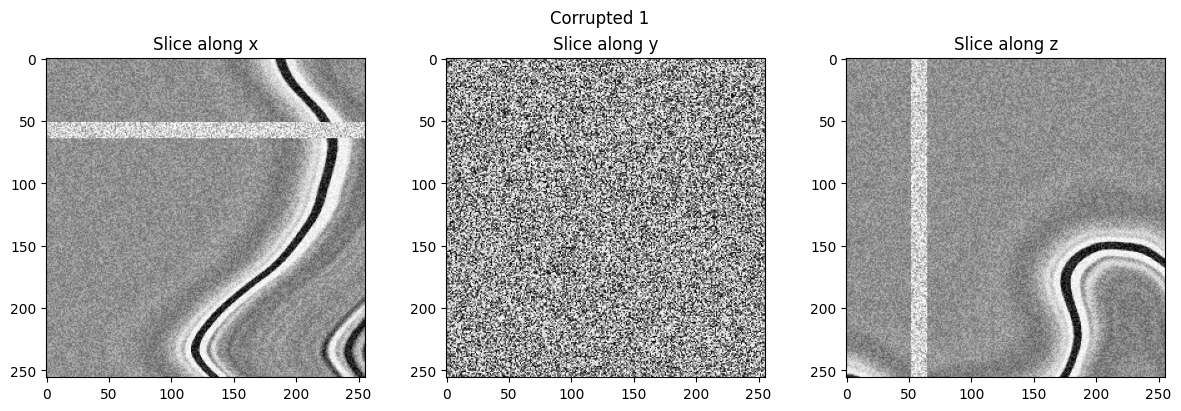

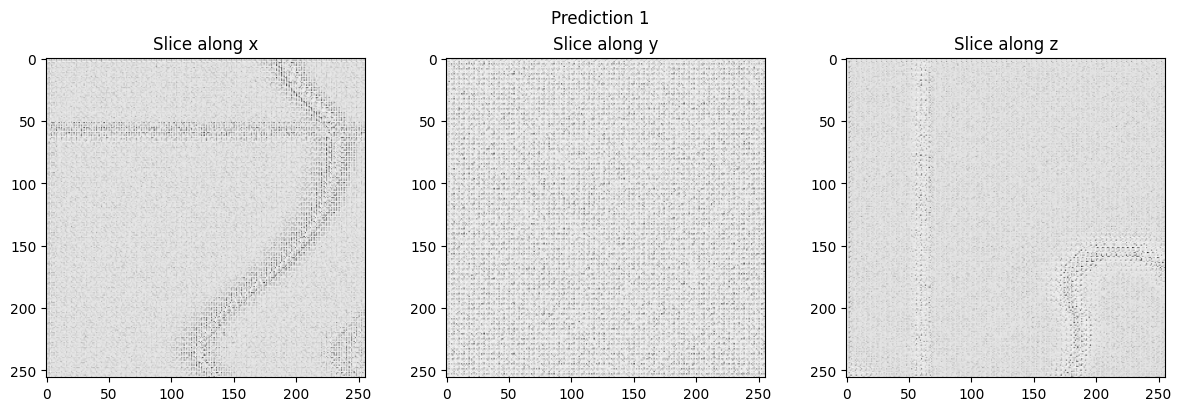

In [64]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(train_loader):
    prediction = gan_2(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

In [248]:
gan.prepare_data()

In [249]:
dataiter = iter(gan.train_data)

In [250]:
sample = (next(dataiter))

In [251]:
sample.keys()

dict_keys(['target', 'image', 'mask'])

In [252]:
sample['image'].shape

torch.Size([1, 256, 256, 256])

In [253]:
original_pt = sample['target'].as_tensor()[0]
corrupted_pt = sample['image'].as_tensor()[0]

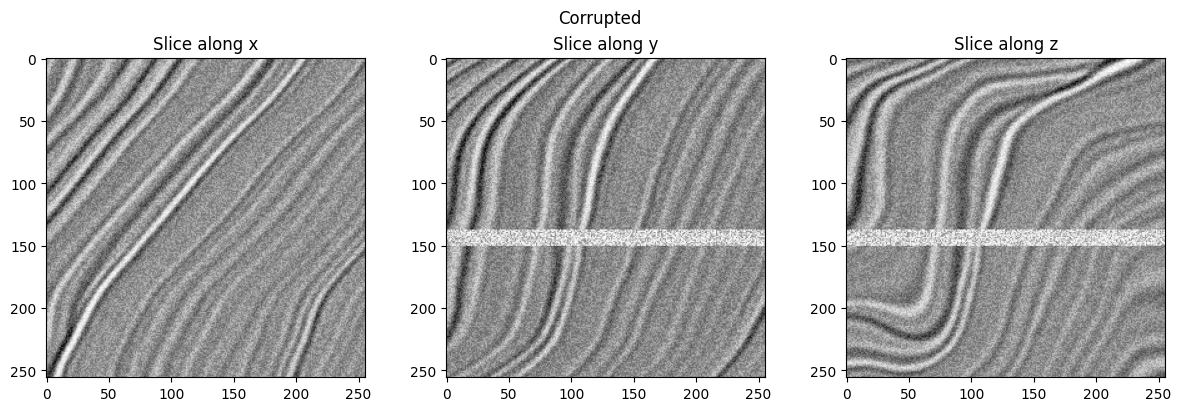

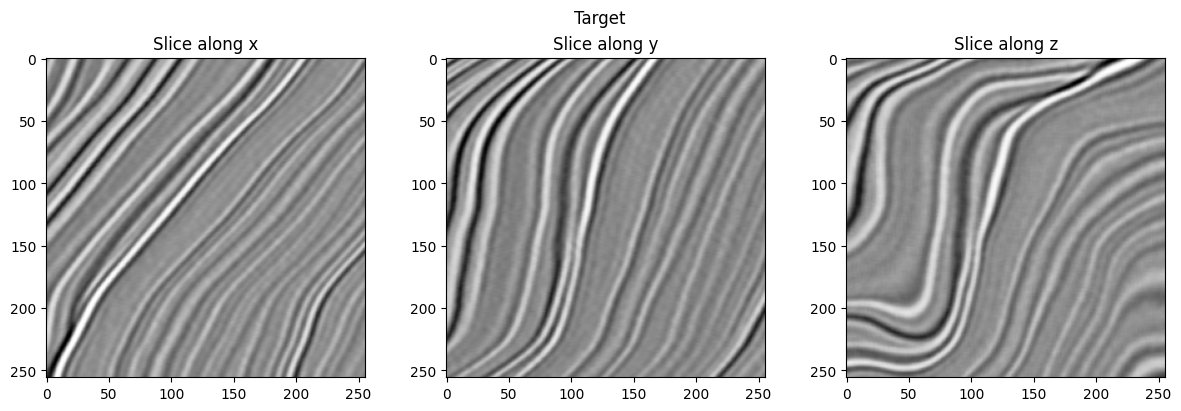

In [254]:
visualize_slices(nib.Nifti1Image(corrupted_pt.numpy(), np.eye(4)), 100, 100, 100, 'Corrupted')
visualize_slices(nib.Nifti1Image(original_pt.numpy(), np.eye(4)), 100, 100, 100, 'Target')

In [92]:
perturbated_original = original_pt.numpy() + np.random.rand(*original_pt.shape) * 0.5

In [184]:
perturbated_corrupted = corrupted_pt + (sample['mask'][0] * torch.rand(*corrupted_pt.shape))

In [193]:
torch.sum(corrupted_pt + sample['mask'][0] * torch.rand(*sample['mask'][0].shape))

tensor([[[188.7586, 179.9655, 164.1379,  ..., 140.6897, 139.5172, 136.5862],
         [189.9310, 181.1379, 164.1379,  ..., 141.2759, 138.9310, 134.8276],
         [191.1035, 180.5517, 162.3793,  ..., 140.1035, 137.1724, 134.2414],
         ...,
         [110.7931, 100.8276,  87.9310,  ..., 120.7586, 130.7241, 148.8965],
         [104.3448,  90.8621,  78.5517,  ..., 124.2759, 138.9310, 158.2758],
         [ 95.5517,  83.2414,  73.8621,  ..., 128.9655, 146.5517, 165.3103]],

        [[174.6897, 153.5862, 134.2414,  ..., 140.1035, 138.3448, 134.2414],
         [172.3448, 153.0000, 135.4138,  ..., 140.1035, 137.1724, 133.6552],
         [168.8276, 149.4828, 133.0690,  ..., 136.5862, 134.2414, 131.8965],
         ...,
         [103.7586,  87.9310,  73.2759,  ..., 121.9310, 137.1724, 157.6897],
         [ 94.9655,  79.1379,  68.0000,  ..., 128.9655, 146.5517, 165.3103],
         [ 85.0000,  73.2759,  69.7586,  ..., 134.2414, 153.5862, 170.0000]],

        [[144.2069, 126.6207, 117.2414,  ...

In [183]:
torch.sum(sample['mask'][0] * torch.rand(*corrupted_pt.shape))

tensor(426269.4062)

In [94]:
corrupted_pt[sample['mask'].numpy()[0]]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [93]:
corrupted_pt[sample['mask'].numpy()[0]] = torch.rand(*corrupted_pt.shape) * 0.5

RuntimeError: shape mismatch: value tensor of shape [256, 256, 256] cannot be broadcast to indexing result of shape [851968]

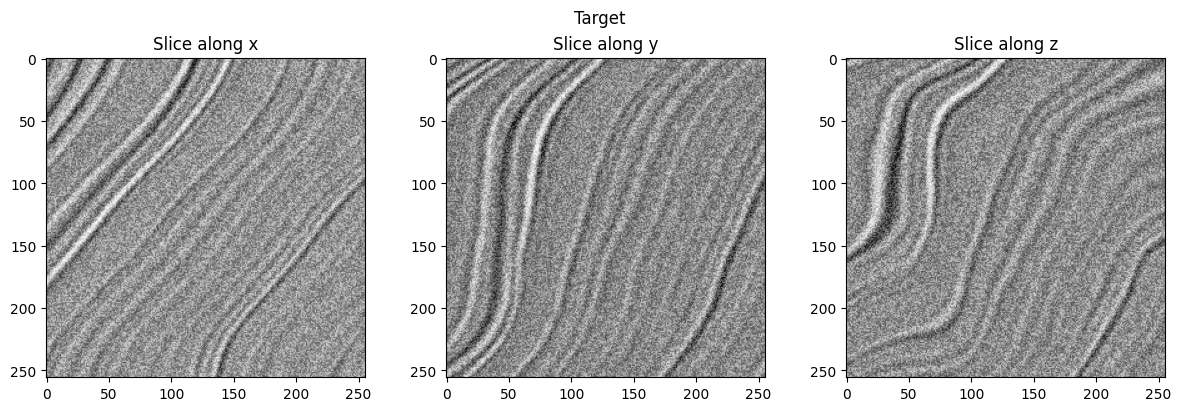

In [55]:
visualize_slices(nib.Nifti1Image(perturbated_original, np.eye(4)), 100, 100, 100, 'Target')

In [87]:
perturbated_corrupted = np.clip(corrupted_pt.numpy() + np.random.rand(*corrupted_pt.shape) * 0.5, 0, 1)

In [86]:
corrupted_pt[100, :, :]

tensor([[0.5290, 0.5725, 0.6549,  ..., 0.5496, 0.5358, 0.5267],
        [0.5358, 0.5977, 0.6893,  ..., 0.5381, 0.5290, 0.5244],
        [0.5564, 0.6389, 0.7419,  ..., 0.5404, 0.5267, 0.5221],
        ...,
        [0.5129, 0.5244, 0.5610,  ..., 0.4809, 0.4923, 0.5038],
        [0.5175, 0.5358, 0.5679,  ..., 0.4900, 0.5061, 0.5175],
        [0.5152, 0.5427, 0.5748,  ..., 0.4946, 0.5061, 0.5152]])

In [75]:
perturbated_corrupted[100, :, :]

array([[0.52896011, 0.57246768, 0.65490299, ..., 0.54956895, 0.53582972,
        0.52667028],
       [0.53582972, 0.59765625, 0.68925107, ..., 0.53811955, 0.52896011,
        0.52438039],
       [0.55643857, 0.63887393, 0.74191809, ..., 0.54040951, 0.52667028,
        0.52209049],
       ...,
       [0.51293105, 0.52438039, 0.56101835, ..., 0.48087284, 0.49232218,
        0.50377154],
       [0.51751077, 0.53582972, 0.56788796, ..., 0.49003235, 0.50606143,
        0.51751077],
       [0.51522088, 0.54269934, 0.57475752, ..., 0.49461207, 0.50606143,
        0.51522088]])

In [73]:
corrupted_pt.shape

torch.Size([256, 256, 256])

In [61]:
sample['mask'].shape

torch.Size([1, 256, 256, 256])

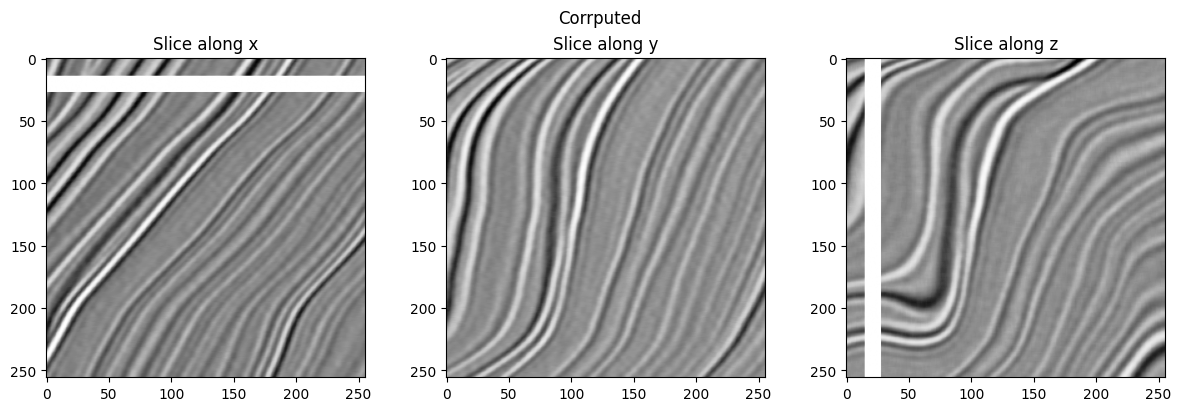

In [185]:
visualize_slices(nib.Nifti1Image(perturbated_corrupted.numpy(), np.eye(4)), 100, 100, 100, 'Corrputed')

In [56]:
sample['mask'].numpy().astype(int)

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

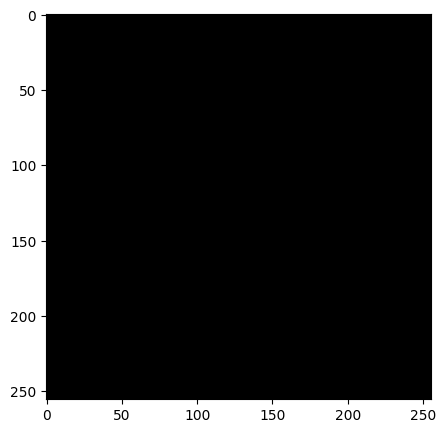

In [40]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['mask'].numpy()[0, :, 100, :], cmap='gray')

In [44]:
sample['mask']

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [34]:
os.listdir(checkpoint_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/gan-2'

In [ ]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

for i, batch in enumerate(gan.val_dataloader()):
    prediction = gan.G(batch['image'])
    print(prediction.shape)
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)
    break